# Análisis de Datos para Showz

A lo largo de este proyecto, se analizará la información recabada para la empresa de venta de entradas a eventos Showz con el objetivo de optimizar los gastos de marketing.

Se tiene la siguiente información sobre las operaciones de Showz:
1) Registros del servidor con datos sobre las visitas a Showz desde enero de 2017 hasta diciembre de 2018.
2) Un archivo con los pedidos en este periodo.
3) Estadísticas de gastos de marketing.

El objetivo del trabajo será identificar:
1) Cómo los clientes usan el servicio.
2) Cuándo empiezan a comprar.
3) Cuánto dinero aporta cada cliente a la compañía.
4) Cuándo los ingresos cubren el costo de adquisición de los clientes.

## Importación de las librerías a usar.

In [1]:
# Importamos las librerías con las que se trabajará el código.
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Paso 1: Carga de datos:

Se leerán los datos a través de los CSV que se tienen con la información de costos, ventas y visitas al sitio web de Showz. Cada archivo se leerá en un Pandas DataFrame.

In [2]:
# Lectura de los archivos:
costos = pd.read_csv("costs_us.csv")
ordenes = pd.read_csv("orders_log_us.csv")
visitas = pd.read_csv("visits_log_us.csv")

print(costos.columns)
print(ordenes.columns)
print(visitas.columns)

Index(['source_id', 'dt', 'costs'], dtype='object')
Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')
Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')


Sabemos que la información recibida ha sido previamente procesada y se encuentra en forma apta para su análisis, por lo que no realizamos una exploración previa para modificar atributos.

## Paso 2: Análisis inicial, cálculos y metricas:

En esta sección obtendremos las métricas más importantes para las áreas de Ventas y Marketing, así como las suficientes para evaluar el tráfico de Visitas en la página de Showz.

### Visitas:

Buscamos responder lo siguiente en cuanto a las visitas del sitio web:
1) ¿Cuántas personas lo usan cada día, semana y mes?
2) ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).
3) ¿Cuál es la duración de cada sesión?
4) ¿Con qué frecuencia los usuarios regresan?

Para responder lo anterior, nos apoyaremos del DF de visitas.

In [3]:
# Iniciamos revisando la información del DF:
visitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Lo único a observar aquí es que las columnas de End Ts y Start Ts no están en un formato de fecha/hora.

In [4]:
# Para calcular cuantas visitas tenemos en los periodos de tiempo día, semana y mes, lo primero será convertir los datos de las columnas End y Start TS a tiempo:
visitas['End Ts'] = pd.to_datetime(visitas['End Ts'])
print("Tipo de dato para End Ts:",visitas['End Ts'].dtype)

visitas['Start Ts'] = pd.to_datetime(visitas['Start Ts'])
print("Tipo de dato para Start Ts:",visitas['Start Ts'].dtype)

Tipo de dato para End Ts: datetime64[ns]
Tipo de dato para Start Ts: datetime64[ns]


In [5]:
# Crearemos las columnas de día del año (valores de 1 a 365), mes (1 a 12), semana (1 a 52) y año.
visitas["doy"] = visitas["Start Ts"].dt.day_of_year
visitas["woy"] = visitas["Start Ts"].dt.isocalendar().week
visitas["mes"] = visitas["Start Ts"].dt.month
visitas["año"] = visitas["Start Ts"].dt.year

visitas.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid,doy,woy,mes,año
77817,touch,2017-10-09 08:50:00,5,2017-10-09 08:49:00,11020187285476979402,282,41,10,2017
157157,desktop,2018-01-25 14:10:00,2,2018-01-25 13:36:00,8056418121947262981,25,4,1,2018
133317,touch,2017-11-30 10:50:00,2,2017-11-30 10:40:00,17956827303229825606,334,48,11,2017
143959,touch,2017-11-27 08:42:00,1,2017-11-27 08:20:00,2639824267109552297,331,48,11,2017
92218,desktop,2018-01-29 12:28:00,5,2018-01-29 12:25:00,10244968468111672561,29,5,1,2018


In [6]:
# Obtenemos usuarios por día:
visitas_dia = visitas.pivot_table(index="doy",
                    columns="año",
                    values="Uid",
                    aggfunc="nunique")

visitas_dia.fillna(0,inplace=True)

visitas_dia.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
año,,,,,,,,
2017,364.0,496.95,522.81,0.0,0.0,430.5,945.00,3319.0
2018,364.0,411.04,523.08,0.0,0.0,0.0,918.25,1997.0


<AxesSubplot: xlabel='doy'>

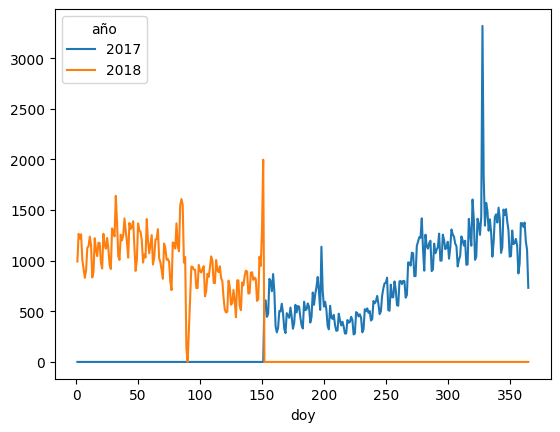

In [7]:
# Graficamos para comprender mejor los datos de visitas por día:
visitas_dia.plot(kind='line')

Este sencillo gráfico nos permite ver que en realidad contamos con la información de una año calendario, por lo mismo, se nos grafica 2018 antes que 2017, pues los días del año (doy: de 1 a 365) para 2018 son previos a los de 2017.

Encontramos el pico más importante a finales de 2017 y parece que la estacionalidad es un factor relevante pues los gráficos empatan a la altura del día 150.

In [8]:
# Hacemos lo mismo para las semanas:
visitas_sem = visitas.pivot_table(index="woy",
                    columns="año",
                    values="Uid",
                    aggfunc="nunique")

visitas_sem.fillna(0,inplace=True)

visitas_sem.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
año,,,,,,,,
2017,52.0,3184.40,3224.61,0.0,0.0,2779.0,6449.25,10586.0
2018,52.0,2641.77,3223.07,0.0,0.0,0.0,5562.25,8111.0


<AxesSubplot: xlabel='woy'>

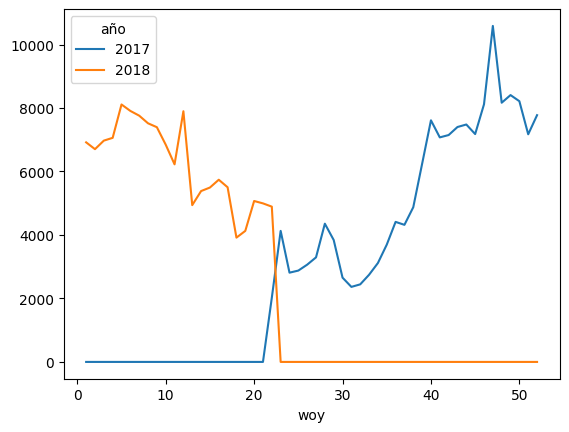

In [9]:
# Esperando un gráfico similar al de días, mostramos las visitas por sem.
visitas_sem.plot(kind='line')

Con otra presentación, se mantienen las observaciones realizadas al gráfico de visitas por día.

In [10]:
# Y para los meses:
visitas_mes = visitas.pivot_table(index="mes",
                    columns="año",
                    values="Uid",
                    aggfunc="nunique")

visitas_mes.fillna(0,inplace=True)

visitas_mes.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
año,,,,,,,,
2017,12.0,12674.50,13134.54,0.0,0.0,12445.0,21654.25,32797.0
2018,12.0,10553.92,13277.20,0.0,0.0,0.0,22624.25,28749.0


<AxesSubplot: xlabel='mes'>

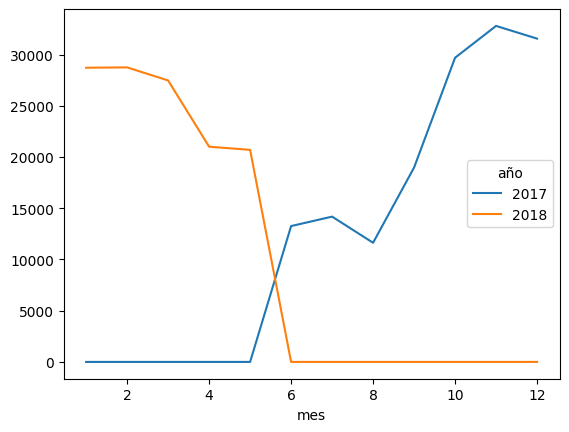

In [11]:
# Graficamos por mes:
visitas_mes.plot(kind='line')

Aunque hemos hecho los gráficos más simples, no es necesario ajustar detalles adicionales para que podamos visualizar el comportamiento de las visitas a lo largo del año de datos con los que contamos para el sitio web de Showz.

También es importante identificar cuantas sesiones se tienen por día, entiendiendo que un mismo usuario puede entrar más de una vez a la página web. Esto nos ayuda a conocer un poco más sobre los patrones de comportamiento de las visitas.

In [12]:
# Obtenemos sesiones por día:
sesiones_dia = visitas.pivot_table(index="doy",
                    columns="año",
                    values="Uid",
                    aggfunc="count")

sesiones_dia.fillna(0,inplace=True)

sesiones_dia.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
año,,,,,,,,
2017,364.0,539.70,577.49,0.0,0.0,457.5,993.75,4042.0
2018,364.0,447.66,571.49,0.0,0.0,0.0,999.50,2256.0


Con la cantidad de visitas y sesiones por día, podemos calcular cuantas veces entra un usuario en promedio a la página web:

In [13]:
# Unimos visitas y sesiones por día en usarios_dia:
usuarios_dia = pd.merge(visitas_dia,sesiones_dia,suffixes=("_vis","_ses"),left_index=True,right_index=True)

usuarios_dia["2017_ses_por_us"] = usuarios_dia["2017_ses"] / usuarios_dia["2017_vis"]
usuarios_dia["2018_ses_por_us"] = usuarios_dia["2018_ses"] / usuarios_dia["2018_vis"]

usuarios_dia.fillna(0,inplace=True)

usuarios_dia.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
año,,,,,,,,
2017_vis,364.0,496.95,522.81,0.0,0.0,430.50,945.00,3319.00
2018_vis,364.0,411.04,523.08,0.0,0.0,0.00,918.25,1997.00
2017_ses,364.0,539.70,577.49,0.0,0.0,457.50,993.75,4042.00
2018_ses,364.0,447.66,571.49,0.0,0.0,0.00,999.50,2256.00
2017_ses_por_us,364.0,0.63,0.53,0.0,0.0,1.06,1.08,1.22
2018_ses_por_us,364.0,0.45,0.54,0.0,0.0,0.00,1.08,1.15


Seguimos con las preguntas planteadas en la sección, buscaremos ahora la duración de la sesión en segundos:

In [14]:
# Creamos la nueva columna donde restamos los tiempos de fin e inicio de la sesión:
visitas["dur_ses"] = (visitas["End Ts"] - visitas["Start Ts"]).dt.seconds

dur_ses_prom = visitas["dur_ses"].mean()

print(f"Duración promedio: {dur_ses_prom:.2f} s por sesión.")

Duración promedio: 643.51 s por sesión.


Por último, obtendremos los días en que los usuarios iniciaron sesión y cuantos días fueron:

In [15]:
# Creamos la columna de dia_uni con los días y años:
visitas["dia_uni"] = visitas["año"].astype("str") + '_' + visitas["doy"].astype("str")

# Hacemos una tabla dinámica:
usuarios = visitas.pivot_table(index="Uid",
                               columns="dia_uni",
                               values="Start Ts",
                               aggfunc="count")

usuarios.fillna(0,inplace=True)

In [16]:
# Calculamos las visitas acumuladas por usuario:
visitas_acum = usuarios.cumsum(axis=1)

# Establecemos el total de visitas:
visitas_tot = visitas_acum[visitas_acum.columns[-1]]

# Sacamos el promedio:
prom_visitas = visitas_tot.mean()

# El total de días del sitio:
dias_tot = (visitas['End Ts'].max() - visitas['Start Ts'].min()).days

# Resultados:
print(f"Cada usuario visitó el sitio {prom_visitas:.2f} veces en promedio.")
print(f"En un total de {dias_tot:.0f} días de análisis del sitio, significa que los usuarios entraron cada {dias_tot/prom_visitas:.2f} días en promedio.")

Cada usuario visitó el sitio 1.58 veces en promedio.
En un total de 365 días de análisis del sitio, significa que los usuarios entraron cada 231.72 días en promedio.


In [17]:
# Validamos la premisas original del rango de tiempo del que se tiene información:
print("Primer día de información:",visitas['Start Ts'].min())
print("Último día de información:",visitas['End Ts'].max())
print("Días totales de información:",visitas['End Ts'].max()-visitas['Start Ts'].min())

Primer día de información: 2017-06-01 00:01:00
Último día de información: 2018-06-01 01:26:00
Días totales de información: 365 days 01:25:00


Queremos asegurarnos de que no haya sesgos dependiendo en el momento en que se han adquirido a los usuarios, por lo anterior, dividiremos a estos en grupos de cohortes determinados por el periodo mensual en que realizaron su primer visita.

### Ventas:

En esta sección analizaremos los datos de las ventas desde el sitio web de Showz con la intención de responder:
1) ¿Cuándo empieza la gente a comprar respecto a su registro en la plataforma?
2) ¿Cuántos pedidos hacen durante un período de tiempo dado?
3) ¿Cuál es el tamaño promedio de compra?
4) ¿Cuánto dinero traen? (LTV: valor del usuario a lo largo del tiempo)

Nos basaremos en la información de los DataFrames de visitas y órdenes.

In [18]:
# Ya hemos revisado y trabajado con visitas, daremos un vistazo a órdenes:
ordenes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [19]:
# Convertiremos la columna de la fecha de compra a una fecha:
ordenes['Buy Ts'] = pd.to_datetime(ordenes['Buy Ts'])

print("Tipo de dato para Buy Ts:",ordenes['Buy Ts'].dtype)

Tipo de dato para Buy Ts: datetime64[ns]


In [20]:
# Obtenemos la lista de usuarios únicos y su fecha de primera visita:
usuarios_visitas = visitas.groupby('Uid').agg({'Start Ts':'min'})

# Obtenemos la lista de usuarios únicos y su fecha de primera compra:
usuarios_compras = ordenes.groupby('Uid').agg({'Buy Ts':'min'})

# Ligamos los conjuntos:
usuarios_prim_compra = pd.merge(usuarios_visitas,usuarios_compras,how='inner',left_index=True,right_index=True)

# Obtenemos el tiempo a la primera compra en días:
usuarios_prim_compra['d_prim_compra'] = (usuarios_prim_compra['Buy Ts'] - usuarios_prim_compra['Start Ts']).dt.days.astype(int)

# Presentamos la estadística:
usuarios_prim_compra['d_prim_compra'].describe().round(2)

count    36523.00
mean        16.73
std         46.96
min          0.00
25%          0.00
50%          0.00
75%          2.00
max        363.00
Name: d_prim_compra, dtype: float64

In [21]:
# Para obtener la cantidad de pedidos que se hacen por periodos de días, semanas, meses y año, primero debemos obtener dichos periodos de la tabla de ordenes:
ordenes['año'] = ordenes['Buy Ts'].dt.year
ordenes['mes'] = ordenes['Buy Ts'].dt.month
ordenes["woy"] = ordenes['Buy Ts'].dt.isocalendar().week
ordenes["doy"] = ordenes['Buy Ts'].dt.day_of_year

ordenes.sample(5)

,Buy Ts,Revenue,Uid,año,mes,woy,doy
15255,2017-10-30 09:00:00,2.44,18024310145178444655,2017,10,44,303
9476,2017-09-28 15:13:00,11.00,6731421022966725351,2017,9,39,271
23836,2017-12-13 15:22:00,0.15,15753541342309809018,2017,12,50,347
41511,2018-03-24 12:48:00,2.93,2790642358204841861,2018,3,12,83
29939,2018-01-18 15:10:00,2.44,8929732821982589731,2018,1,3,18


In [22]:
# Calculamos el número total de usuarios únicos que han comprado:
usuarios_unicos_compras = ordenes['Uid'].nunique()
print(usuarios_unicos_compras,"usuarios que han realizado compras.")

# Calculamos el número total de usuarios únicos:
usuarios_unicos_tot = visitas['Uid'].nunique()
print(usuarios_unicos_tot,"usuarios que han entrado al sitio.")

print(f"Porcentaje de usuarios compradores: {usuarios_unicos_compras/usuarios_unicos_tot:.2%}")

36523 usuarios que han realizado compras.
228169 usuarios que han entrado al sitio.
Porcentaje de usuarios compradores: 16.01%


In [23]:
# Agrupamos por año:
ordenes_año = ordenes.groupby('año').agg({'Uid':'count'})

ordenes_año

,Uid
año,
2017,27467
2018,22948


Como sabemos que en realidad tenemos un año calendario:

In [24]:
# Las compras por año salen:
print(f"Los usuarios realizan {ordenes_año['Uid'].sum()} compras al año en total.")
print(f"Esto es {ordenes_año['Uid'].sum() / usuarios_unicos_compras:.2f} compras al año por usuario que realiza compras;")
print(f"y {ordenes_año['Uid'].sum() / usuarios_unicos_tot:.2f} compras al año por usuario que entra al sistema.")

Los usuarios realizan 50415 compras al año en total.
Esto es 1.38 compras al año por usuario que realiza compras;
y 0.22 compras al año por usuario que entra al sistema.


In [25]:
# Agrupamos por mes (y año):
ordenes_mes = ordenes.groupby(['año','mes']).agg({'Uid':'count'})

ordenes_mes

Uid
año  mes      
2017 6    2354
     7    2363
     8    1807
     9    3387
     10   5679
     11   5659
     12   6218
2018 1    4721
     2    5281
     3    5326
     4    3273
     5    4346
     6       1

In [26]:
# Obtenemos las compras promedio al mes:
ordenes_mes_prom = ordenes_mes['Uid'].sum() / 12

# Imprimimos resultados:
print(f"Se realizan {ordenes_mes_prom:.2f} compras en promedio al mes.")
print(f"Esto es {ordenes_mes_prom/usuarios_unicos_compras:.2f} compras promedio al mes por cada usuario comprador o,")
print(f"{ordenes_mes_prom/usuarios_unicos_tot:.2f} compras promedio al mes por usuario registrado.")

Se realizan 4201.25 compras en promedio al mes.
Esto es 0.12 compras promedio al mes por cada usuario comprador o,
0.02 compras promedio al mes por usuario registrado.


In [27]:
# Para las compras por semana hacemos lo mismo:
ordenes_semana = ordenes.groupby(['año','woy']).agg({'Uid':'count'})

ordenes_semana

Uid
año  woy      
2017 22    340
     23    938
     24    343
     25    371
     26    460
     27    477
     28    636
     29    716
     30    381
     31    314
     32    325
     33    392
     34    480
     35    588
     36    666
     37    668
     38    826
     39   1110
     40   1666
     41   1270
     42   1140
     43   1132
     44   1059
     45    919
     46   1257
     47   1894
     48   1387
     49   1520
     50   1388
     51   1184
     52   1620
2018 1    1006
     2     942
     3     991
     4    1128
     5    1442
     6    1272
     7    1368
     8    1347
     9    1252
     10   1293
     11   1007
     12   1418
     13    862
     14    733
     15    698
     16    890
     17    890
     18    547
     19    635
     20   1004
     21   1027
     22   1196

In [28]:
# Obtenemos las compras promedio a la semana:
ordenes_sem_prom = ordenes_semana['Uid'].mean()

# Imprimimos resultados:
print(f"Se realizan {ordenes_sem_prom:.2f} compras en promedio a la semana.")
print(f"Esto es {ordenes_sem_prom/usuarios_unicos_compras:.2f} compras promedio aa la semana por cada usuario comprador o,")
print(f"{ordenes_sem_prom/usuarios_unicos_tot:.2f} compras promedio a la semana por usuario registrado.")

Se realizan 951.23 compras en promedio a la semana.
Esto es 0.03 compras promedio aa la semana por cada usuario comprador o,
0.00 compras promedio a la semana por usuario registrado.


In [29]:
# Para calcular el valor (tamaño) promedio de cada compra:
val_prom_orden = ordenes['Revenue'].mean()

print(f"El valor/tamaño promedio de cada compra es de ${val_prom_orden:.2f}.")

El valor/tamaño promedio de cada compra es de $5.00.


In [30]:
# Calculamos el LTV de los usuarios compradores:
ordenes_por_usuario = ordenes_año['Uid'].sum() / usuarios_unicos_compras
ltv_usuarios = val_prom_orden * ordenes_por_usuario

print(f"Los usuarios dejan ${ltv_usuarios:.2f} a Showz en un año.")

Los usuarios dejan $6.90 a Showz en un año.


#### División por cohortes:

El último mes no lo queremos considerar porque es incompleto; sin embargo, al solo ser una única compra, será más sencillo simplemente dividir el total de compras entre 12 meses de un año.

In [31]:
# Creamos un df de resumen para obtener los usuarios y su primer visita:
prim_visita = visitas.groupby('Uid').agg({'Start Ts':'min'})

# Calculamos la cohorte:
prim_visita["Cohorte"] = prim_visita['Start Ts'].dt.to_period("M")

prim_visita.sample(5)

,Start Ts,Cohorte
Uid,,
15784878250951077250,2018-03-25 15:32:00,2018-03
6922331645844193404,2017-07-18 18:16:00,2017-07
12828923700690002979,2017-10-04 13:46:00,2017-10
14813051750484581147,2018-02-10 10:59:00,2018-02
4978424517150860286,2017-08-16 09:14:00,2017-08


In [32]:
# Unimos la cohorte con el df de visitas:
prim_visita.reset_index(inplace=True)

visitas_coh = pd.merge(visitas,prim_visita[['Uid','Cohorte']],how='left',left_on='Uid',right_on='Uid')

visitas_coh.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid,doy,woy,mes,año,dur_ses,dia_uni,Cohorte
240694,desktop,2018-02-11 20:00:00,4,2018-02-11 19:57:00,8561562709983972136,42,6,2,2018,180,2018_42,2018-02
20560,desktop,2017-06-19 12:46:00,1,2017-06-19 12:38:00,11680900754697023979,170,25,6,2017,480,2017_170,2017-06
150280,touch,2018-03-19 10:55:00,4,2018-03-19 10:55:00,16369928756549166128,78,12,3,2018,0,2018_78,2018-03
343960,desktop,2017-12-10 20:33:00,5,2017-12-10 20:31:00,545870042680326914,344,49,12,2017,120,2017_344,2017-12
177776,touch,2017-10-12 10:35:00,3,2017-10-12 10:20:00,13221171863652364330,285,41,10,2017,900,2017_285,2017-10


In [33]:
# Unimos la cohorte con el df de ordenes:
ordenes_coh = pd.merge(ordenes,prim_visita[['Uid','Cohorte']],how='left',left_on='Uid',right_on='Uid')

ordenes_coh.sample(5)

,Buy Ts,Revenue,Uid,año,mes,woy,doy,Cohorte
1610,2017-06-18 15:28:00,2.44,5946350350109914346,2017,6,24,169,2017-06
40697,2018-03-19 22:04:00,1.75,2527988376290436099,2018,3,12,78,2018-03
20577,2017-11-27 23:21:00,7.33,13391836040043944514,2017,11,48,331,2017-11
10703,2017-10-04 23:24:00,0.37,8097459152264840001,2017,10,40,277,2017-10
48239,2018-05-21 11:38:00,7.33,13815450002032599535,2018,5,21,141,2018-05


In [34]:
# Obtenemos el periodo de la visita:
ordenes_coh['per_orden'] = ordenes_coh['Buy Ts'].dt.to_period("M")
# Obtenemos las órdenes por cohorte:
ordenes_cohorte = ordenes_coh.groupby('Cohorte').agg({'Uid':'count','per_orden':'nunique'})

ordenes_cohorte.columns = ['Ordenes','Meses_Activa']

ordenes_cohorte['Ord_Prom_Mes'] = ordenes_cohorte['Ordenes'] / ordenes_cohorte['Meses_Activa']

ordenes_cohorte['LTV'] = val_prom_orden * ordenes_cohorte['Ord_Prom_Mes']

ordenes_cohorte

,Ordenes,Meses_Activa,Ord_Prom_Mes,LTV
Cohorte,,,,
2017-06,6397,12,533.083333,2665.228451
2017-07,3545,11,322.272727,1611.249852
2017-08,2638,10,263.800000,1318.906860
2017-09,4346,9,482.888889,2414.273951
2017-10,6233,8,779.125000,3895.349915
2017-11,5983,7,854.714286,4273.269655
2017-12,5236,6,872.666667,4363.025221
2018-01,3864,5,772.800000,3863.727148
2018-02,3866,4,966.500000,4832.158758


<AxesSubplot: xlabel='Cohorte'>

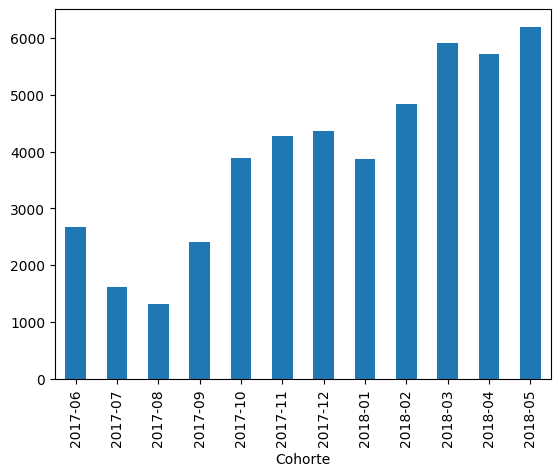

In [35]:
# Graficamos para mejorar la visibilidad de los datos:
ordenes_cohorte['LTV'].plot(kind='bar')

Las últimas cohortes en unirse al sitio tienden a gastar más que las más antiguas.

### Marketing:

En esta última sección analizaremos los costos en que incurre Showz para atraer usuarios en las distintas fuentes de anuncios en las que se apoya para responder:
1) ¿Cuánto dinero se gastó?  (Total/por fuente de adquisición/a lo largo del tiempo) 
2) ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?
3) ¿Cuán rentables eran las inversiones? (ROMI)

In [36]:
# Trabajamos con el DF de costos:
costos_fuente = costos.groupby('source_id').agg({'costs':'sum'})

costos_fuente.columns = ["Costo_Acum"]

costos_fuente

,Costo_Acum
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


In [37]:
# Calculamos el número de usuarios por fuente:
usuarios_fuente = visitas.groupby('Source Id').agg({'Uid':'nunique'})

usuarios_fuente.columns = ["Cant_Usuarios"]

usuarios_fuente

,Cant_Usuarios
Source Id,
1,18999
2,26245
3,74756
4,83525
5,56974
6,6
7,34
9,9264
10,8067


In [38]:
# Unimos los dataframes anteriores:
costos_fuente = costos_fuente.merge(usuarios_fuente,how='left',left_index=True,right_index=True)

# Creamos la columna calculada:
costos_fuente["Costo_por_Usuario"] = costos_fuente['Costo_Acum'] / costos_fuente['Cant_Usuarios']

costos_fuente

,Costo_Acum,Cant_Usuarios,Costo_por_Usuario
source_id,,,
1,20833.27,18999,1.096546
2,42806.04,26245,1.631017
3,141321.63,74756,1.890439
4,61073.60,83525,0.731201
5,51757.10,56974,0.908434
9,5517.49,9264,0.595584
10,5822.49,8067,0.721766


In [39]:
# Obtenemos cuanto ha gastado cada usuario y su la fuente mediante la cual fue "adquirido":
ing_usuarios = ordenes.groupby('Uid').agg({'Revenue':'sum'})

ing_usuarios.reset_index()

# Ligamos con la fuente mediante la cual fueron adquiridos:
ing_usuarios = ing_usuarios.merge(visitas[['Uid','Source Id']],how='left',left_on='Uid',right_on='Uid')

# Verificamos:
ing_usuarios.sample(5)

,Uid,Revenue,Source Id
97230,18408912903794486210,3.67,4
40505,7475723700219702834,5.62,2
2467,472367036322950196,4.58,2
44262,8158546050605142370,3.36,3
53868,10100265958405570359,7.94,2


In [40]:
# Agrupamos ingresos por fuente de adquisisión:
ing_fuente = ing_usuarios.groupby('Source Id').agg({'Uid':'nunique','Revenue':'sum'})

ing_fuente.columns = ['Usuarios_compradores','Ingresos']

ing_fuente

,Usuarios_compradores,Ingresos
Source Id,,
1,7138,2298200.17
2,7305,2638189.21
3,13846,296687.96
4,14253,496690.17
5,10156,1181477.14
7,1,1.22
9,2793,36342.25
10,1773,14619.23


In [41]:
# Unimos los ingresos por fuente con los costos por fuente:
fuentes = pd.merge(ing_fuente,costos_fuente,how='left',left_index=True,right_index=True)

fuentes.fillna(0,inplace=True)

# Calculamos el ROMI por fuente:
fuentes['ROMI'] = (fuentes['Ingresos'] - fuentes['Costo_Acum']) / fuentes['Costo_Acum']

fuentes.reset_index(inplace=True)

fuentes

,Source Id,Usuarios_compradores,Ingresos,Costo_Acum,Cant_Usuarios,Costo_por_Usuario,ROMI
0,1,7138,2298200.17,20833.27,18999.0,1.096546,109.313944
1,2,7305,2638189.21,42806.04,26245.0,1.631017,60.631237
2,3,13846,296687.96,141321.63,74756.0,1.890439,1.099381
3,4,14253,496690.17,61073.60,83525.0,0.731201,7.132649
4,5,10156,1181477.14,51757.10,56974.0,0.908434,21.827344
5,7,1,1.22,0.00,0.0,0.000000,inf
6,9,2793,36342.25,5517.49,9264.0,0.595584,5.586736
7,10,1773,14619.23,5822.49,8067.0,0.721766,1.510821


In [42]:
# Obtenemos los costos por mes y por fuente:
costos['dt'] = pd.to_datetime(costos['dt'])

print("Tipo de dato para Start Ts:",costos['dt'].dtype)

Tipo de dato para Start Ts: datetime64[ns]


In [43]:
# Obtenemos el mes y año:
costos['año'] = costos['dt'].dt.year
costos['mes'] = costos['dt'].dt.month

costos['periodo'] = costos['dt'].dt.to_period('M')

costos.sample(5)

,source_id,dt,costs,año,mes,periodo
1874,9,2017-07-29,5.26,2017,7,2017-07
1829,9,2017-06-14,5.08,2017,6,2017-06
1022,3,2018-03-24,272.83,2018,3,2018-03
1378,4,2018-03-17,219.68,2018,3,2018-03
1777,5,2018-04-23,159.89,2018,4,2018-04


In [44]:
# Obtenemos el periodo de visitas:
visitas['periodo'] = visitas['Start Ts'].dt.to_period('M')

visitas.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid,doy,woy,mes,año,dur_ses,dia_uni,periodo
283536,desktop,2017-11-10 17:39:00,1,2017-11-10 17:22:00,12869801667763685675,314,45,11,2017,1020,2017_314,2017-11
196679,desktop,2018-02-25 19:22:00,10,2018-02-25 19:21:00,10299253301789708521,56,8,2,2018,60,2018_56,2018-02
25895,desktop,2017-12-30 06:37:00,5,2017-12-30 06:33:00,10028221478389192829,364,52,12,2017,240,2017_364,2017-12
350944,desktop,2017-10-10 12:17:00,9,2017-10-10 12:08:00,7183449281609565887,283,41,10,2017,540,2017_283,2017-10
326737,desktop,2017-11-13 00:33:00,1,2017-11-13 00:31:00,1398221154793727414,317,46,11,2017,120,2017_317,2017-11


In [45]:
# Ahora para las ordenes:
ordenes['periodo'] = ordenes['Buy Ts'].dt.to_period('M')

ordenes.sample(5)

,Buy Ts,Revenue,Uid,año,mes,woy,doy,periodo
4921,2017-08-05 14:55:00,9.78,8914283385046053824,2017,8,31,217,2017-08
50105,2018-05-31 12:56:00,4.89,17102744273701749751,2018,5,22,151,2018-05
25657,2017-12-23 23:15:00,2.02,14559344013088431073,2017,12,51,357,2017-12
3582,2017-07-17 11:16:00,4.89,10417564410024574760,2017,7,29,198,2017-07
16088,2017-11-04 14:01:00,8.33,7040331811010947809,2017,11,44,308,2017-11


In [46]:
# Obtenemos cuantos usuarios únicos entraron por periodo y fuente:
fuentes_mes = visitas.groupby(['periodo','Source Id']).agg({'Uid':'nunique'})

fuentes_mes.reset_index(level=['periodo','Source Id'],inplace=True)

# Renombramos columnas:
fuentes_mes.columns = ['periodo','Source Id','Usuarios']

fuentes_mes.sample(5)

,periodo,Source Id,Usuarios
13,2017-07,6,1
12,2017-07,5,3727
60,2017-12,10,621
77,2018-02,10,1088
44,2017-11,2,4193


In [47]:
# Agregamos el costo por adquisición de usuario según la fuente:
fuentes_mes = fuentes_mes.merge(fuentes[['Source Id', 'Costo_por_Usuario']],how='left',left_on='Source Id',right_on='Source Id')

fuentes_mes.sample(5)

,periodo,Source Id,Usuarios,Costo_por_Usuario
91,2018-04,7,1,0.000000
40,2017-10,7,5,0.000000
82,2018-03,5,4613,0.908434
10,2017-07,3,4068,1.890439
97,2018-05,4,7275,0.731201


In [48]:
# Calculamos el costo total por fuente por periodo:
fuentes_mes['Costo_fuente_periodo'] = fuentes_mes['Usuarios'] * fuentes_mes['Costo_por_Usuario']

fuentes_mes.fillna(0,inplace=True)

fuentes_mes.sample(5)

,periodo,Source Id,Usuarios,Costo_por_Usuario,Costo_fuente_periodo
61,2018-01,1,2142,1.096546,2348.800692
34,2017-09,10,502,0.721766,362.326761
49,2017-11,7,1,0.000000,0.000000
51,2017-11,10,888,0.721766,640.928613
77,2018-02,10,1088,0.721766,785.281904


In [49]:
# Obtenemos cuanto a comprado cada usuario por fuente y periodo:
ing_usuarios_mes = ordenes.groupby(['Uid','periodo']).agg({'Revenue':'sum'})

ing_usuarios_mes.reset_index(inplace=True)

ing_usuarios_mes.sample(5)

,Uid,periodo,Revenue
25298,11350817748550463409,2018-03,0.73
33861,15175305400399463840,2018-02,0.92
20153,9071222754221964783,2018-01,1.28
24352,10934268142562263067,2017-10,4.28
27694,12434687411817827453,2017-10,4.40


In [50]:
# Unimos con la fuente:
ing_usuarios_mes = ing_usuarios_mes.merge(ing_usuarios[['Uid','Source Id']],how='left',left_on='Uid',right_on='Uid')

ing_usuarios_mes.sample(5)

,Uid,periodo,Revenue,Source Id
88632,8106704914757275229,2017-09,4.89,9
68014,6331227992824097525,2017-12,0.37,4
94626,8857495976726509994,2018-04,3.36,2
25468,3202777663400921908,2017-11,2.20,2
39751,3644482766749211722,2018-02,133.63,1


In [51]:
# Obtenemos el ingreso por fuente y periodo:
ing_fuente_mes = ing_usuarios_mes.groupby(['periodo','Source Id']).agg({'Revenue':'sum'})

ing_fuente_mes.reset_index(inplace=True)

ing_fuente_mes.sample(5)

,periodo,Source Id,Revenue
42,2017-11,10,1622.45
44,2017-12,2,686899.45
17,2017-08,4,17058.65
16,2017-08,3,9987.26
24,2017-09,3,31889.05


In [52]:
# Unimos los ingresos con los costos por fuente y periodo:
fuentes_mes_glob = pd.merge(fuentes_mes,ing_fuente_mes,how='inner',left_on=['periodo','Source Id'],right_on=['periodo','Source Id'])

fuentes_mes_glob.sample(5)

,periodo,Source Id,Usuarios,Costo_por_Usuario,Costo_fuente_periodo,Revenue
28,2017-09,10,502,0.721766,362.326761,667.19
27,2017-09,9,781,0.595584,465.151089,3148.46
43,2017-12,1,2735,1.096546,2999.052237,280553.96
56,2018-01,10,925,0.721766,667.633972,540.72
24,2017-09,3,5825,1.890439,11011.805002,31889.05


Con la tabla de fuentes por mes y periodo obtendremos las tablas necesarias para graficar.

In [53]:
# Costos por fuente y periodo:
fuentes_mes_costos = fuentes_mes_glob.pivot_table(index='periodo',
                                                  columns='Source Id',
                                                  values='Costo_fuente_periodo',
                                                  aggfunc='sum')

fuentes_mes_costos.fillna(0,inplace=True)

fuentes_mes_costos.round(2)

Source Id,1,2,3,4,5,7,9,10
periodo,,,,,,,,
2017-06,1065.84,2498.72,7988.99,2658.65,2637.18,0.0,448.47,308.19
2017-07,1148.08,2895.06,7690.30,3008.16,3385.73,0.0,334.72,228.08
2017-08,870.66,2079.55,6457.74,2287.93,2857.93,0.0,365.09,176.11
2017-09,1529.68,3474.07,11011.81,3931.67,4480.39,0.0,465.15,362.33
2017-10,2379.50,5463.91,16131.11,6956.65,6835.96,0.0,621.19,668.36
2017-11,3059.36,6838.85,19263.57,8209.93,5909.36,0.0,886.23,640.93
2017-12,2999.05,6038.02,17380.69,8618.67,5652.27,0.0,734.95,448.22
2018-01,2348.80,5167.06,16123.55,7492.62,5212.59,0.0,630.72,667.63
2018-02,2325.77,5152.38,16420.35,7133.60,5407.00,0.0,617.03,785.28


Hacemos un mapa de temperatura ("heatmap") que nos ayude a entender mejor la información de la tabla.

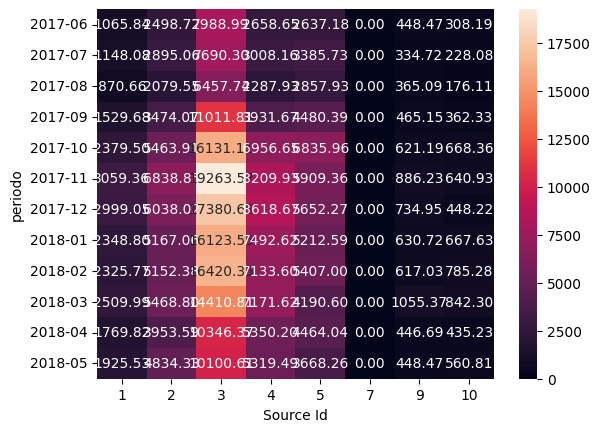

In [54]:
# Hacemos el heatmap de los costos:
hm_costos = sns.heatmap(fuentes_mes_costos,annot=True,fmt=".2f")

plt.rcParams["figure.figsize"] = (15,25)

plt.show()

In [55]:
# Ingresos por fuente y periodo:
fuentes_mes_ing = fuentes_mes_glob.pivot_table(index='periodo',
                                                  columns='Source Id',
                                                  values='Revenue',
                                                  aggfunc='sum')

fuentes_mes_ing.fillna(0,inplace=True)

fuentes_mes_ing.round(2)

Source Id,1,2,3,4,5,7,9,10
periodo,,,,,,,,
2017-06,51524.95,49626.01,7467.82,13644.17,23407.59,0.00,1520.66,930.09
2017-07,111710.63,63334.23,11665.24,20875.41,44119.00,0.00,1777.77,504.96
2017-08,86273.21,54832.22,9987.26,17058.65,40644.90,1.22,2139.29,625.29
2017-09,279308.11,239718.35,31889.05,62662.48,121096.12,0.00,3148.46,667.19
2017-10,187071.49,282287.68,28700.13,62606.07,120985.05,0.00,4478.87,1360.70
2017-11,201333.82,136536.47,26717.04,50455.38,76210.45,0.00,5122.15,1622.45
2017-12,280553.96,686899.45,61873.58,82430.32,327846.25,0.00,4569.23,902.03
2018-01,138532.86,217416.01,21120.49,37645.69,87011.97,0.00,2063.83,540.72
2018-02,195325.46,267674.91,26827.78,49034.61,124226.25,0.00,2794.91,1701.84


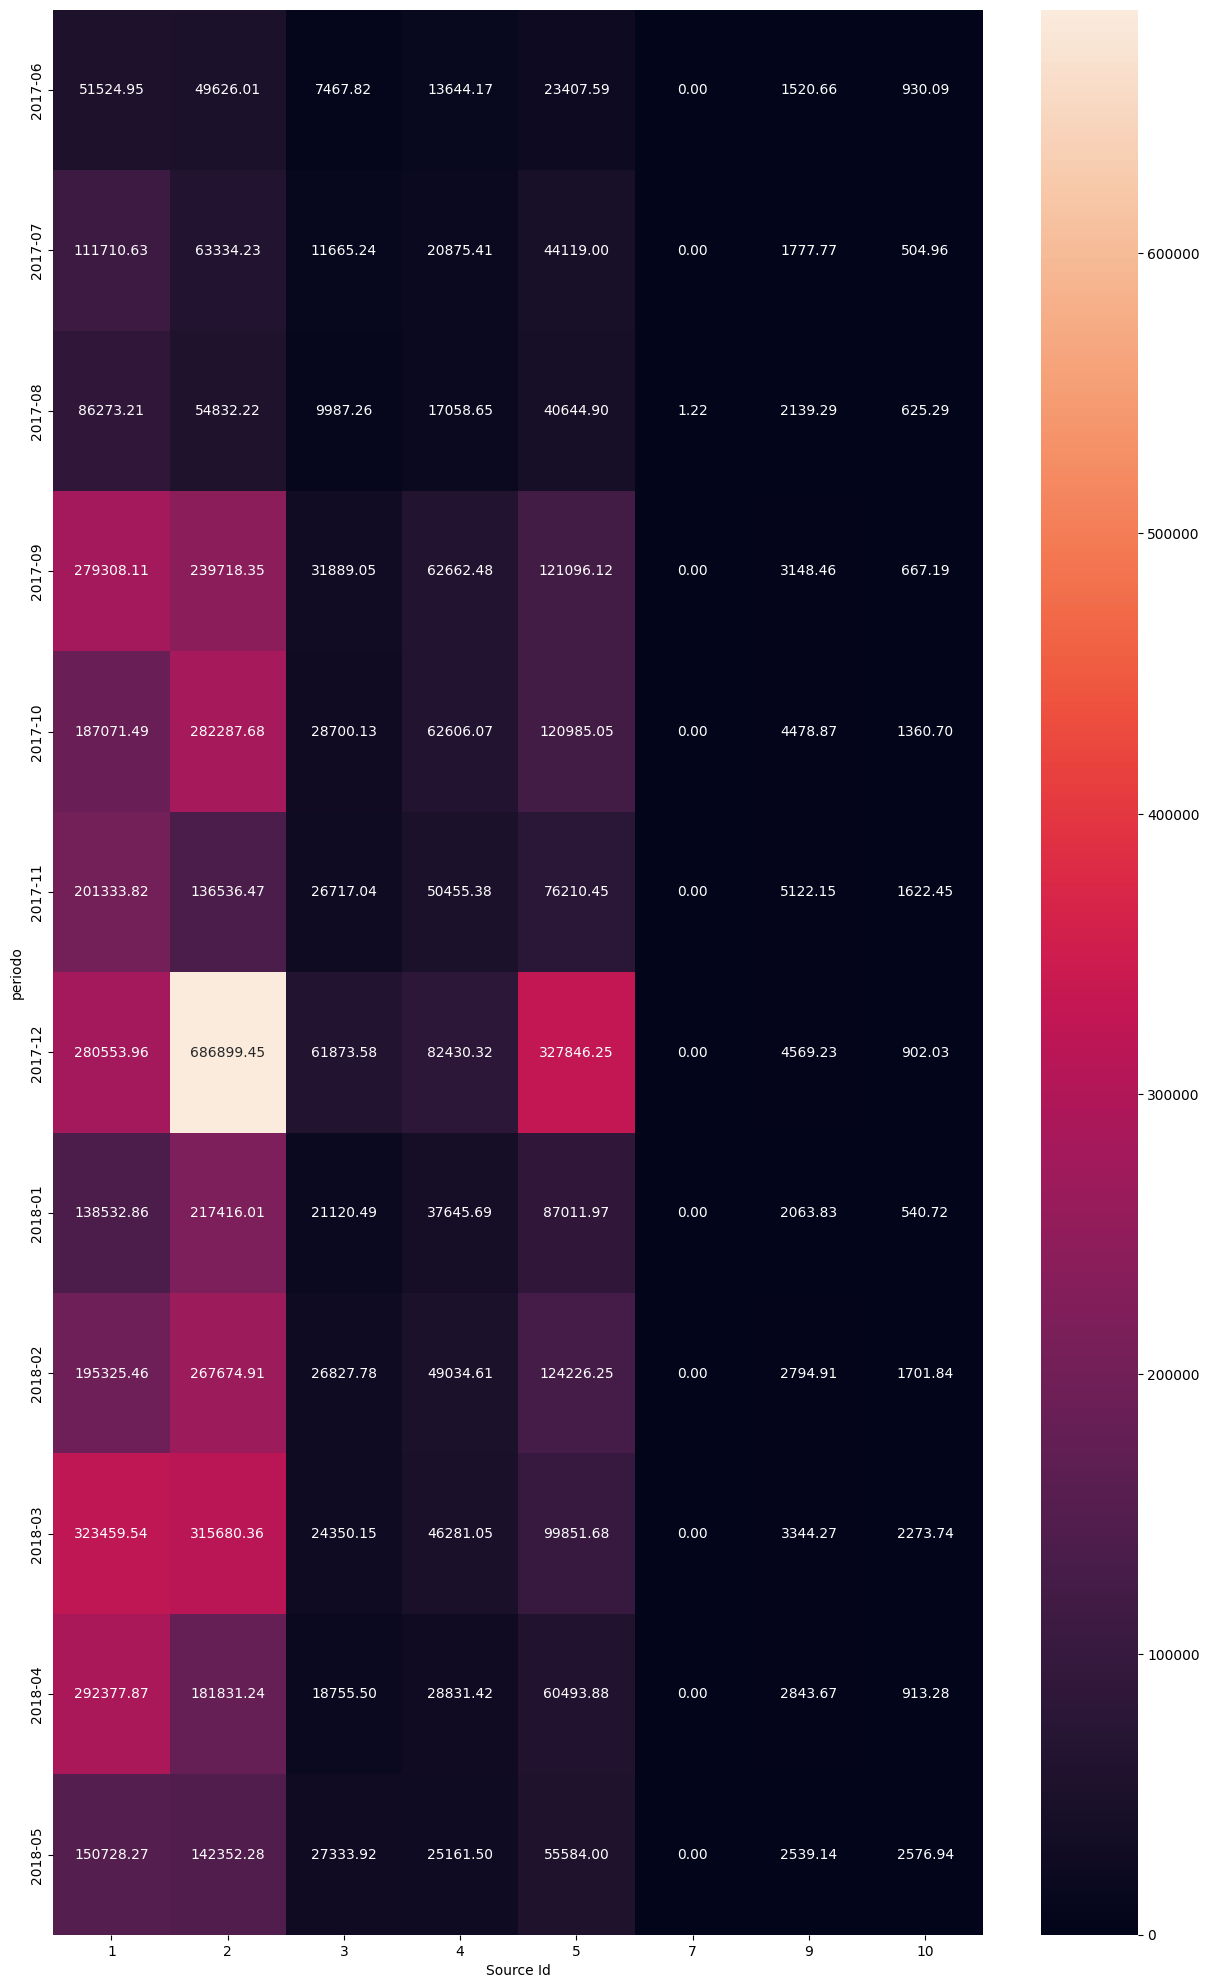

In [56]:
# Hacemos el heatmap de los ingresos:
hm_ing = sns.heatmap(fuentes_mes_ing,annot=True,fmt=".2f")

plt.show()

In [57]:
# Reiniciamos los índices de nuestras tablas de fuentes:
fuentes_mes_costos.reset_index(inplace=True)
fuentes_mes_ing.reset_index(inplace=True)

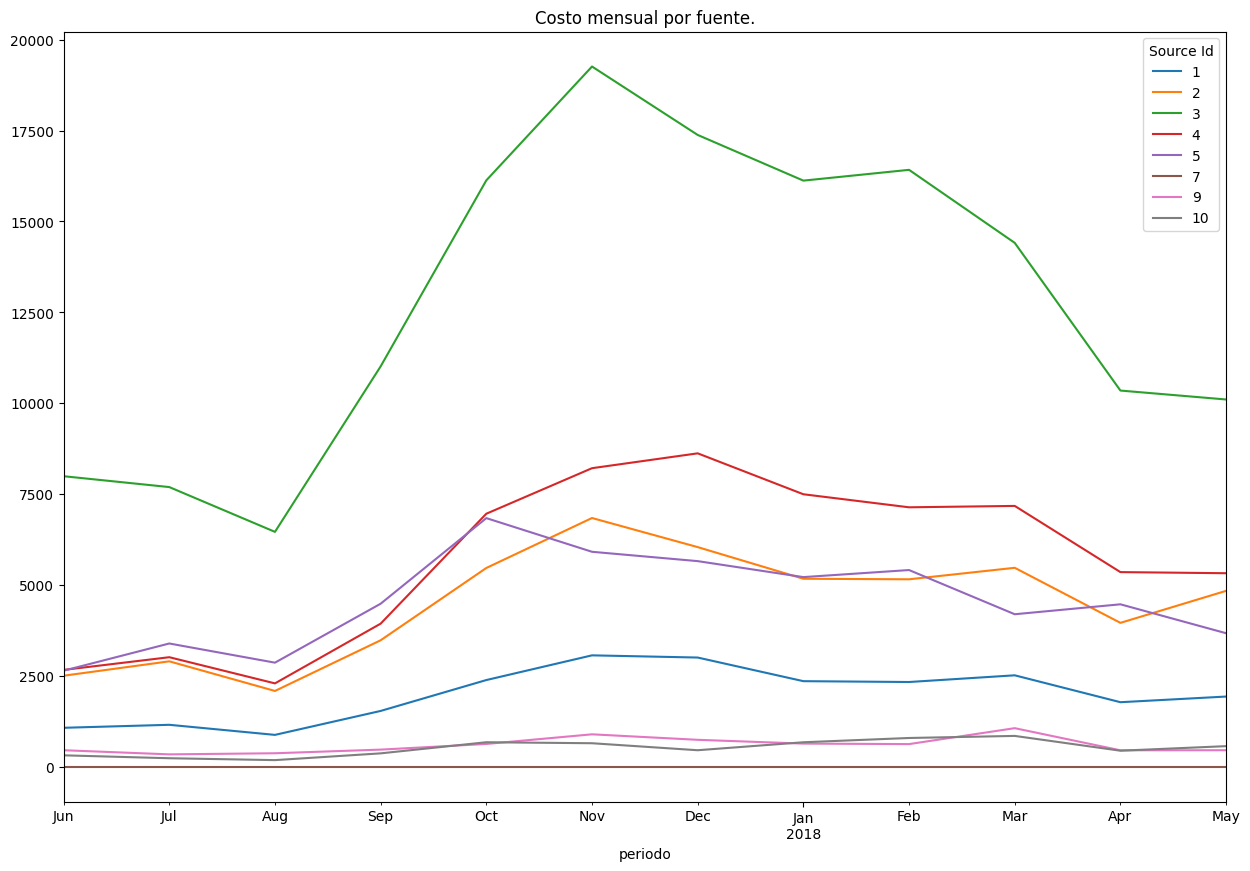

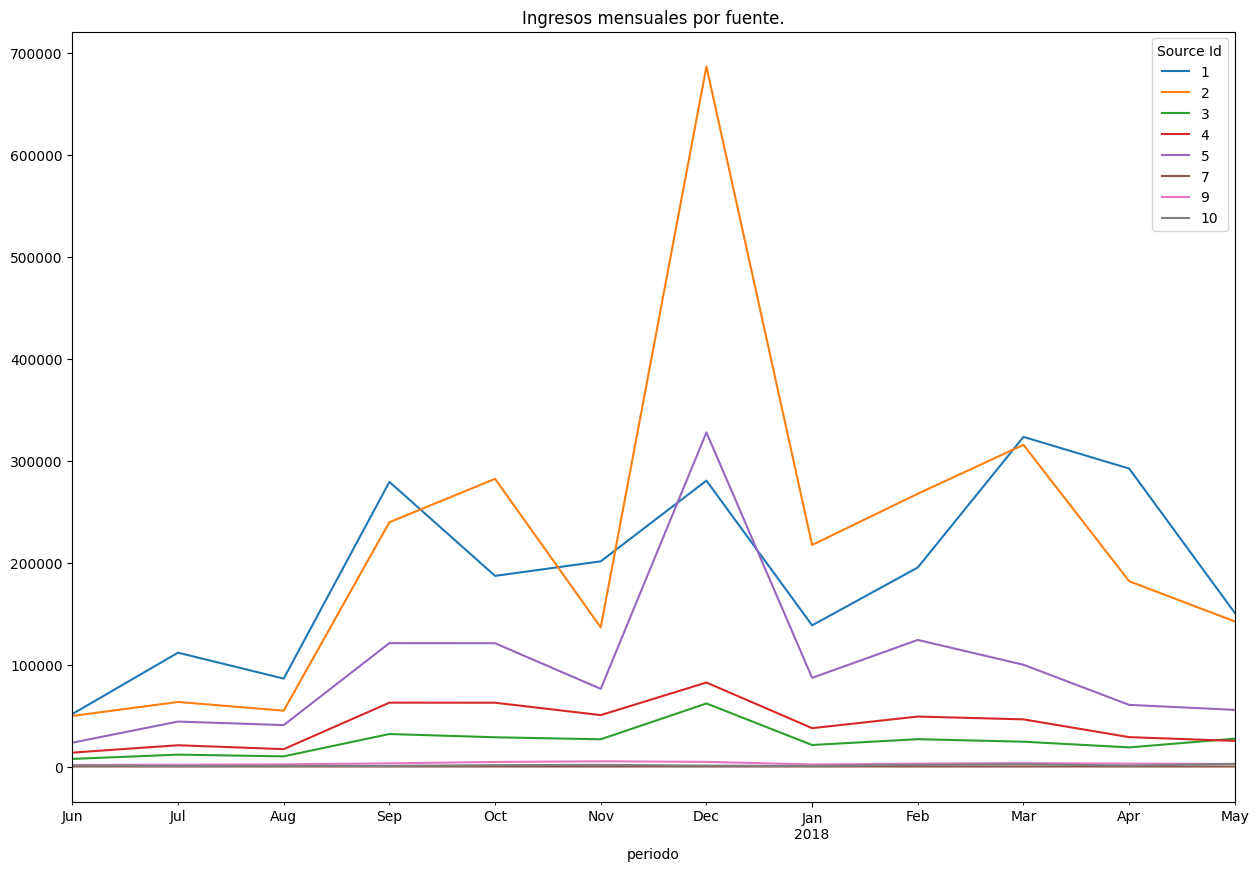

In [58]:
# Graficamos:
graf_costos = fuentes_mes_costos.plot(kind='line',
                                      x='periodo',
                                      figsize=[15,10],
                                      sharex=True,sharey=True,
                                      title='Costo mensual por fuente.')

graf_ing = fuentes_mes_ing.plot(kind='line',
                                x='periodo',
                                figsize=[15,10],
                                sharex=True,sharey=True,
                                title='Ingresos mensuales por fuente.')


plt.show()

#### ROMI por cohorte:

Continuando con lo que ya trabajamos sobre dividir a los usuarios por cohortes según la fecha en que se conectaron por vez primera al sitio web de Showz, calcularemos el ROMI por fuente y por cohorte para ver si existen diferencias.

In [59]:
# Repetimos el procedimiento seguido pero tomando en cuenta a las cohortes:
usuarios_fte_coh = visitas_coh.groupby(['Source Id','Cohorte']).agg({'Uid':'nunique'})

usuarios_fte_coh.columns = ['Cant_Usuarios']

usuarios_fte_coh

Cant_Usuarios
Source Id Cohorte               
1         2017-06           1513
          2017-07           1282
          2017-08            910
          2017-09           1526
          2017-10           2239
...                          ...
10        2018-01            839
          2018-02            933
          2018-03           1003
          2018-04            492
          2018-05            628

[102 rows x 1 columns]

In [60]:
# Para obtener el costo por usuario por fuente por día, vamos a calcular cuantos usuarios se conectaron por fuente por día:
usuarios_fte_dia = visitas.groupby(['Start Ts','Source Id']).agg({'Uid':'count'})

usuarios_fte_dia.columns = ['Cant_Usuarios']

usuarios_fte_dia.reset_index(inplace= True)

usuarios_fte_dia['dia'] = usuarios_fte_dia['Start Ts'].dt.to_period("d")

usuarios_fte_dia.head(3)

,Start Ts,Source Id,Cant_Usuarios,dia
0,2017-06-01 00:01:00,5,1,2017-06-01
1,2017-06-01 00:02:00,3,2,2017-06-01
2,2017-06-01 00:04:00,3,1,2017-06-01


In [61]:
# Obtenemos el día para el df de costos y evitar fallas al ligar:
costos['dia'] = costos['dt'].dt.to_period("d")

In [62]:
# Ahora unimos la cantidad de usuarios a nuestro df de costos para calcular el costo promedio por usuario:
costos_fte_prom = pd.merge(costos,usuarios_fte_dia,how='left',left_on=['source_id','dia'],right_on=['Source Id','dia'])

costos_fte_prom.head(3)

,source_id,dt,costs,año,mes,periodo,dia,Start Ts,Source Id,Cant_Usuarios
0,1,2017-06-01,75.2,2017,6,2017-06,2017-06-01,2017-06-01 00:09:00,1.0,1.0
1,1,2017-06-01,75.2,2017,6,2017-06,2017-06-01,2017-06-01 01:18:00,1.0,1.0
2,1,2017-06-01,75.2,2017,6,2017-06,2017-06-01,2017-06-01 02:37:00,1.0,1.0


In [63]:
# Quitamos columnas innecesarias:
costos_fte_prom.drop(columns=['dt', 'año', 'mes', 'periodo','Start Ts','Source Id'],inplace=True)

costos_fte_prom.columns

Index(['source_id', 'costs', 'dia', 'Cant_Usuarios'], dtype='object')

In [64]:
# Calculamos el costo por usuario:
costos_fte_prom["costo_usuario"] = costos_fte_prom["costs"] / costos_fte_prom["Cant_Usuarios"]

In [65]:
# Agrupamos los valores de costos por fuente y obtenemos el costo promedio por usuario por fuente:
costos_fte_usuario_prom = costos_fte_prom.groupby("source_id").agg({'costo_usuario':'mean'})

costos_fte_usuario_prom.reset_index(inplace=True)

costos_fte_usuario_prom

,source_id,costo_usuario
0,1,65.537269
1,2,129.560259
2,3,411.806460
3,4,170.570512
4,5,150.305789
5,9,17.285715
6,10,18.487397


In [66]:
# Unimos el costo promedio por usuario con la cantidad de usuarios por fuente y cohorte que visitaron el sitio:
usuarios_fte_coh.reset_index(inplace=True)

fte_coh_costos = pd.merge(usuarios_fte_coh,costos_fte_usuario_prom,how="left",left_on="Source Id",right_on='source_id')

# Calculamos el costo total:
fte_coh_costos["Costo_tot"] = fte_coh_costos["costo_usuario"] * fte_coh_costos["Cant_Usuarios"]

fte_coh_costos

,Source Id,Cohorte,Cant_Usuarios,source_id,costo_usuario,Costo_tot
0,1,2017-06,1513,1.0,65.537269,99157.887376
1,1,2017-07,1282,1.0,65.537269,84018.778332
2,1,2017-08,910,1.0,65.537269,59638.914416
3,1,2017-09,1526,1.0,65.537269,100009.871867
4,1,2017-10,2239,1.0,65.537269,146737.944372
...,...,...,...,...,...,...
97,10,2018-01,839,10.0,18.487397,15510.926405
98,10,2018-02,933,10.0,18.487397,17248.741759
99,10,2018-03,1003,10.0,18.487397,18542.859576
100,10,2018-04,492,10.0,18.487397,9095.799513


In [73]:
# Ahora obtenemos cuanto ha generado cada cohorte por fuente:
ordenes_coh_fte = pd.merge(ordenes_coh[["Revenue",'Uid']],visitas_coh[["Uid","Source Id","Cohorte"]],how="inner",left_on="Uid",right_on="Uid")

# Agrupamos para sacar el ingreso por fuente y cohorte:
fte_coh_ing = ordenes_coh_fte.groupby(["Source Id","Cohorte"]).agg({"Revenue":"sum"})

fte_coh_ing.reset_index(inplace=True)

fte_coh_ing

,Source Id,Cohorte,Revenue
0,1,2017-06,1644037.17
1,1,2017-07,70177.78
2,1,2017-08,214287.37
3,1,2017-09,85773.41
4,1,2017-10,54984.00
...,...,...,...
80,10,2018-01,664.16
81,10,2018-02,522.17
82,10,2018-03,1437.73
83,10,2018-04,431.19


In [79]:
# Unimos los costos e ingresos:
fte_coh_global = pd.merge(fte_coh_costos,fte_coh_ing,how='inner',left_on=["Source Id","Cohorte"],right_on=["Source Id","Cohorte"])

# Quitamos las columnas innecesarias:
fte_coh_global.drop(columns=['source_id', 'costo_usuario'],inplace=True)

# Renombramos las columnas:
fte_coh_global.columns = ["Fuente","Cohorte","Cant_Usuarios","Costo_tot","Ingreso_tot"]

# Calculamos el ROMI:
fte_coh_global["ROMI"] = (fte_coh_global["Ingreso_tot"] - fte_coh_global["Costo_tot"]) / fte_coh_global["Costo_tot"]

# Calculamos el CAC:
fte_coh_global["CAC"] = fte_coh_global["Costo_tot"] / fte_coh_global["Cant_Usuarios"]

fte_coh_global

,Fuente,Cohorte,Cant_Usuarios,Costo_tot,Ingreso_tot,ROMI,CAC
0,1,2017-06,1513,99157.887376,1644037.17,15.579994,65.537269
1,1,2017-07,1282,84018.778332,70177.78,-0.164737,65.537269
2,1,2017-08,910,59638.914416,214287.37,2.593080,65.537269
3,1,2017-09,1526,100009.871867,85773.41,-0.142351,65.537269
4,1,2017-10,2239,146737.944372,54984.00,-0.625291,65.537269
...,...,...,...,...,...,...,...
80,10,2018-01,839,15510.926405,664.16,-0.957181,18.487397
81,10,2018-02,933,17248.741759,522.17,-0.969727,18.487397
82,10,2018-03,1003,18542.859576,1437.73,-0.922464,18.487397
83,10,2018-04,492,9095.799513,431.19,-0.952595,18.487397


Nos apoyamos de algunos gráficos para facilitar la lectura de los datos:

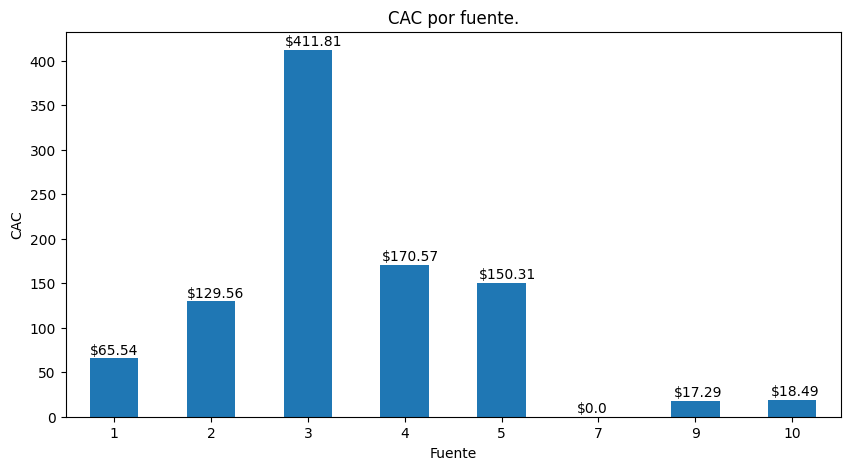

In [96]:
# Graficamos el costo de adquirir clientes:
cac_graf = fte_coh_global.groupby('Fuente').agg({'CAC':'mean'})

ax = cac_graf.plot(kind='bar',figsize=[10,5],legend=False,rot=0,
              title="CAC por fuente.",ylabel="CAC")

for p in ax.patches:
    ax.annotate("$" + str(p.get_height().round(2)), (p.get_x() * 1.005, p.get_height() + 5))

plt.show()

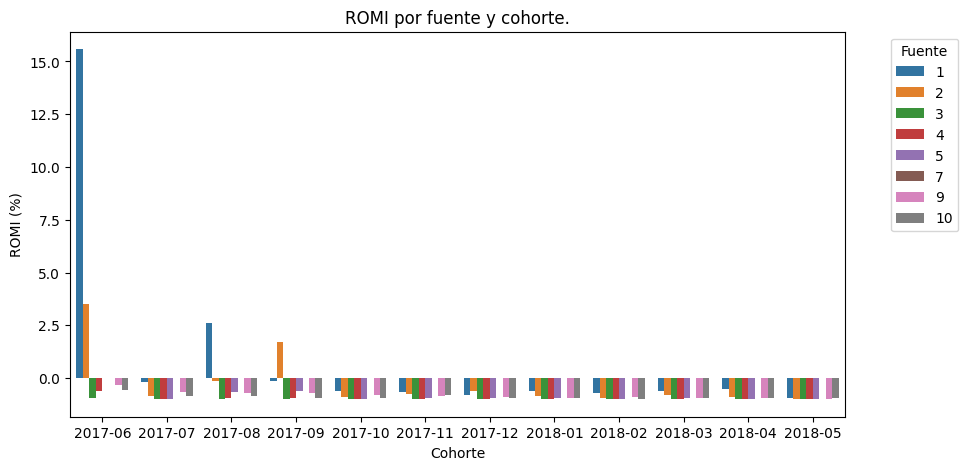

In [109]:
# Del dataframe fte_coh_global, haremos un gráfico de barras en el que se muestre el ROMI por fuente y cohorte, en el eje x se presenta la cohorte
# y se agrupan horizontalmente las fuentes, en el eje y se presenta el ROMI, con colores diferentes se identifica a cada fuente.
# Se presenta una leyenda que indica a qué fuente corresponde cada color.
plt.figure(figsize=(10,5))
sns.barplot(data=fte_coh_global,x="Cohorte",y="ROMI",hue="Fuente")
plt.title("ROMI por fuente y cohorte.")
plt.ylabel("ROMI (%)")
plt.legend(title="Fuente", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Paso 3: Conclusiones.

¿Qué fuentes/plataformas recomendarías?  Fundamenta tu selección: ¿en qué métricas te enfocaste?  ¿Por qué? ¿Qué conclusiones sacaste después de encontrar los valores métricos?

En base a lo que se ha explorado mediante los datos que Showz nos ha compartido de un año de operación de su sitio web, la fuente 3 es la menos rentable y la fuente 2 la que más ingresos trajo; sin embargo, la fuente 1 fue, proporcionalmente al nivel de inversión más rentable con un ROMI del 100%. Para futuras inversiones, las fuentes **1** y **2** son en las que se deberían enforcar los esfuerzos más grandes.

El cálculo del ROMI ha resultado una métrica muy útil que, respealdada por los gráficos muestra con claridad cuales fuentes de captación de nuevos usuarios son mejores.

Para este proyecto, el cáculo del LTV de los usuarios no ha resultado particularmente útil ya que se desconocen los costos directos, solo teniendo consto de atracción de los usuarios. Lo que si ha sido ilustrativo es ver que, en promedio, solo un 16% de los usuarios que entran al sitio terminan haciendo una transacción y solo pocos de ellos repiten.

El ejercicio se ha realizado analizando por usuario y por grupos de cohortes. Las cohortes las hemos definido como el grupo de usuarios según su primer visita al sitio de Showz. Al realizar el análisis por cohorte, pudimos validar que solo las fuentes 1 y 2 han generado utilidades, sin embargo, esto no ha sido para todas las cohortes y el analizar a mayor profundidad las causas raíz del por qué la forma de atraer clientes genera o no utilidades deberá ser un siguiente paso para Showz.